# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/full_model_no_multicollinearity/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
print(f'{len(df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

df[independent_fields].describe()


Index(['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPu

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,5.028689e-01,4.028818e-01,9.854712e-02,3.752564e-01,5.918652e-02,4.195026e-01,1.184329e-01,2.984282e-01,1.689049e-01,1.431109e-01,...,1.145499e-02,1.968431e-02,7.960149e-02,1.344227e-01,9.530649e-03,1.751597e-02,8.878922e-02,7.431632e-02,3.897225e-02,5.331061e-02
std,4.710872e-01,4.523492e-01,2.907154e-01,4.479614e-01,2.284392e-01,2.256374e-01,7.151420e-02,1.867567e-01,1.842988e-01,1.868169e-01,...,5.399123e-02,8.007008e-02,1.179461e-01,1.749526e-01,5.258238e-02,8.241773e-02,1.050750e-01,9.861962e-02,9.868933e-02,1.123964e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,1.658186e-01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.774194e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433434e-01,7.525668e-02,2.972268e-01,9.318519e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,5.416341e-02,3.541864e-02,0.000000e+00,0.000000e+00
75%,1.000000e+00,9.390244e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.860562e-01,1.505134e-01,4.382091e-01,3.095545e-01,2.756683e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,1.365586e-01,1.118571e-01,0.000000e+00,4.670041e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Log-odds linearity


### Visual checking


untransformed
IntraProjectSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.500000
0.25    0.862069
0.40    0.954545
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: IntraProjectSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.75, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0], y=[0.08248670556433244, 1.6187072959154798, 2.5530583035592027, 2.557853428178161, 2.4951699535875407, 2.4951699535875407, 2.4951699535875407, 2.4951699535875407]
EcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.333333
0.25    0.750000
0.40    0.884615
0.50    0.937500
0.60    0.993333
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: EcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.6099095939521472, 0.8235294117647058, 0.9130434782608696, 0.9597989949748744, 1.0, 1.0, 1.0], y=[0.7878828639791526, 1.233092937436056, 1.7670920977856825, 2.2032466051810062, 2.6504748741996127, 1.8053810330

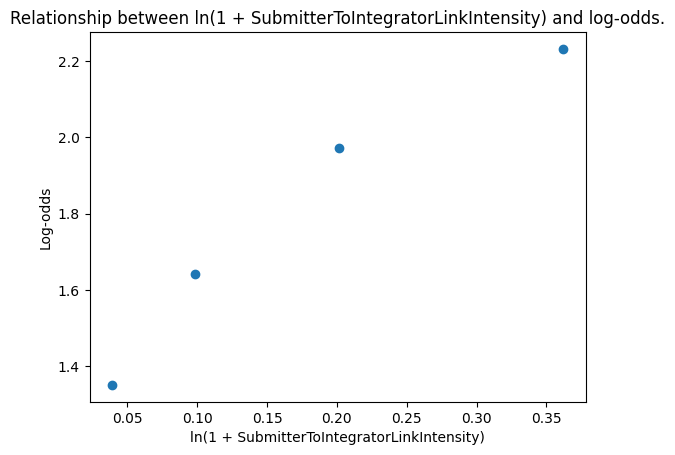

In [2]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame,
    dependent: pd.Series,
    transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include='number')

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r'.*SuccessRate.*', field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[:-len('SuccessRate')]
            count_field = f'ln(1 + {stripped_field}SubmissionCount)'
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f'{field}:')
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[(
                included[field] >= r_start) & (included[field] <= r_end)]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f'Skipped {field} because of division by zero.')
            continue

        print(f'{x=}, {y=}')

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = f'{figure_base_path}/log-odds-independence/{transform_title}/{field}'
        safe_save_fig(output_path)


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include='number')
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field]\
                .apply(transform)
            mn = transformed_independents[field].min()
            mx = transformed_independents[field].max()
            transformed_independents[field] = transformed_independents[field]\
                .apply(lambda x: (x - mn) / (mx - mn))
        test_log_linearity(transformed_independents,
                           dependent, f'{figure_subfolder}/{transform.__name__}')


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value ** 2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value ** 3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, "dependency_model")


## Multicolinearity


In [3]:

# Standardized list of multicollinear fields.
multicollinear_fields = [
    # # Confounds
    # "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",

    # # eco
    # "EcosystemExperienceSubmitterPullRequestSuccessRate",
    # "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    # "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    # "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",

    # # intra-proj
    # # "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    # "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    # "IntraProjectSubmitterPullRequestSuccessRate",
    # "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    # "ln(1 + IntraProjectSubmitterIssueCommentCount)",
]

print(f'Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity.')


Removing 0 / 37 fields to account for multicollinearity.


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}

    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df


tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


                                             variable         VIF
0                         ControlIntegratedBySameUser    3.749158
1                       ControlPullRequestHasComments    4.113391
2          ControlPullRequestHasCommentByExternalUser    1.977710
3                      ControlHasHashTagInDescription    1.594580
4         IntraProjectSubmitterPullRequestSuccessRate    6.024854
5   EcosystemExperienceSubmitterPullRequestSuccess...   33.785767
6   DependencyEcosystemExperienceSubmitterPullRequ...    4.181297
7   NonDependencyEcosystemExperienceSubmitterPullR...   29.165225
8   InversedDependencyEcosystemExperienceSubmitter...    4.926578
9                     SubmitterIsFirstTimeContributor    2.807781
10        ln(1 + ControlPullRequestLifeTimeInMinutes)    4.818820
11        ln(1 + ControlNumberOfCommitsInPullRequest)    3.782002
12  ln(1 + ControlIntraProjectPullRequestExperienc...    5.864616
13  ln(1 + IntraProjectSubmitterPullRequestSubmiss...    9.723996
14  ln(1 +

In [5]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:")
print(problematic_vif)


Problematic VIF fields: 23.
Problematic VIF scores:
                                             variable         VIF
4         IntraProjectSubmitterPullRequestSuccessRate    6.024854
5   EcosystemExperienceSubmitterPullRequestSuccess...   33.785767
7   NonDependencyEcosystemExperienceSubmitterPullR...   29.165225
12  ln(1 + ControlIntraProjectPullRequestExperienc...    5.864616
13  ln(1 + IntraProjectSubmitterPullRequestSubmiss...    9.723996
14  ln(1 + IntraProjectSubmitterPullRequestComment...    6.429266
15  ln(1 + EcosystemExperienceSubmitterPullRequest...  133.038964
16  ln(1 + EcosystemExperienceSubmitterPullRequest...  127.252009
17  ln(1 + DependencyEcosystemExperienceSubmitterP...    8.463244
18  ln(1 + DependencyEcosystemExperienceSubmitterP...    5.525181
19  ln(1 + NonDependencyEcosystemExperienceSubmitt...  101.840135
20  ln(1 + NonDependencyEcosystemExperienceSubmitt...  104.113279
21  ln(1 + InversedDependencyEcosystemExperienceSu...   10.243170
22  ln(1 + InversedDepen

coof_threshold=0.5
Correlating pairs:
[
    [
        "ln(1 + SubmitterToIntegratorLinkIntensity)",
        "ControlIntegratedBySameUser",
        -0.545351291506833
    ],
    [
        "ControlPullRequestHasComments",
        "ControlPullRequestHasCommentByExternalUser",
        0.5019853440878511
    ],
    [
        "SubmitterIsFirstTimeContributor",
        "IntraProjectSubmitterPullRequestSuccessRate",
        -0.7447598996620332
    ],
    [
        "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
        "IntraProjectSubmitterPullRequestSuccessRate",
        0.73614085526418
    ],
    [
        "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
        "IntraProjectSubmitterPullRequestSuccessRate",
        0.5121244287331908
    ],
    [
        "NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
        "EcosystemExperienceSubmitterPullRequestSuccessRate",
        0.9302505804372735
    ],
    [
        "ln(1 + EcosystemExperienceSubmitterPullReq

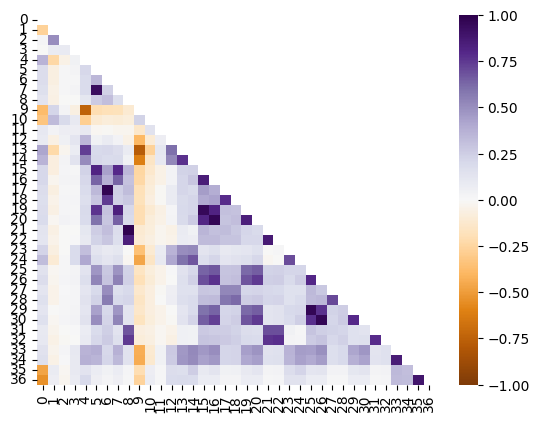

In [6]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr(method='spearman')
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)

output_path = f'{figure_base_path}/correlation_map.png'
safe_save_fig(output_path)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
# print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.


[['ln(1 + SubmitterToIntegratorLinkIntensity)', 'ControlIntegratedBySameUser', -0.545351291506833], ['ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 0.5019853440878511], ['SubmitterIsFirstTimeContributor', 'IntraProjectSubmitterPullRequestSuccessRate', -0.7447598996620332], ['ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'IntraProjectSubmitterPullRequestSuccessRate', 0.73614085526418], ['ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'IntraProjectSubmitterPullRequestSuccessRate', 0.5121244287331908], ['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 0.9302505804372735], ['ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 0.8140073642330329], ['ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 0.6359142079864888], ['ln(1 + NonDepende

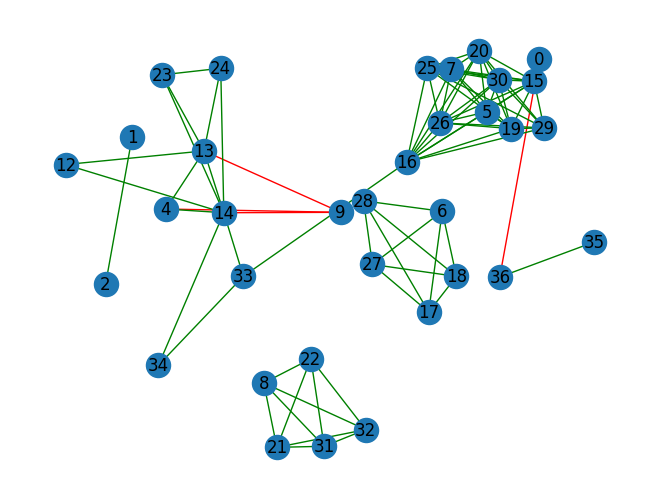

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = {}
    print(correlating_fields)
    for (source, target, coof) in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_color = 'red' if coof < 0.0 else 'green'
        edge_colors[(source_idx, target_idx)] = edge_color
        edge_colors[(target_idx, source_idx)] = edge_color


    # Create an empty graph
    graph = nx.Graph()

    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)
    edge_colors = [edge_colors[(source_idx, target_idx)] for source_idx, target_idx in graph.edges()]

    pos = nx.spring_layout(graph, k=0.8)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)

    output_path = f'{figure_base_path}/correlating_fields.png'
    safe_save_fig(output_path)

    print(json.dumps(enumerated_list))

    with open(f'{figure_base_path}/correlating_fields_legend.txt', "w+", encoding='utf-8') as output_file:
        output_file.write(json.dumps(enumerated_list, indent=4))


In [8]:
print(f'{len(tested_predictors.columns)=}')
print(f'{tested_predictors.columns=}')


len(tested_predictors.columns)=37
tested_predictors.columns=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 

## Outliers

Using cook's distance.


In [9]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(tested_predictors)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(df[pr_merged_key], X_constant,
                       family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(tested_predictors)

# Append absolute standardized residual values
diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(
    lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)


/tmp/ipykernel_48751/2490181039.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_48751/2490181039.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(


,cooks_d,std_resid
371074,0.000542,8.332851
370493,0.000354,5.438637
257558,0.000305,12.693274
257561,0.000298,9.364157
1040378,0.000191,5.436301
264429,0.000189,6.307519
356180,0.000181,8.876220
267130,0.000177,3.076754
356172,0.000167,3.969477
356096,0.000164,7.369382


3.288978714552004e-06
Found outliers: 19168 / 1216221 (1.576%)


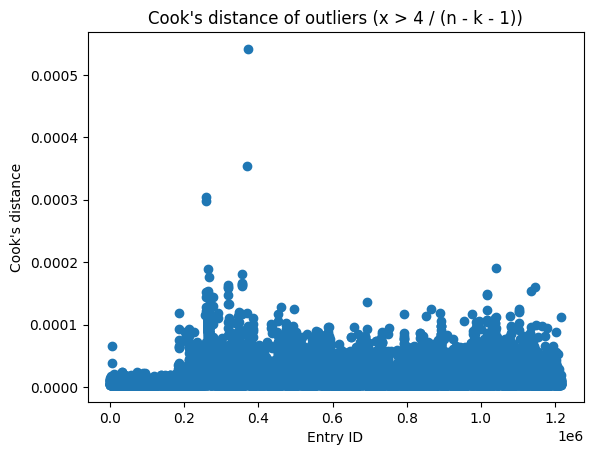

In [10]:
cook_threshold = 4 / (len(tested_predictors) -
                      len(tested_predictors.columns) - 1)
print(cook_threshold)
print(
    f'Found outliers: {len(extreme)} / {len(tested_predictors)} ({100 * len(extreme)/len(tested_predictors):.03f}%)')

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme['cooks_d'])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f'{figure_base_path}/cooks_outliers.png'
safe_save_fig(output_path)


Removes outliers

In [11]:
tested_predictors = tested_predictors.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f'{len(tested_predictors)=}')

len(tested_predictors)=1197053


# Model Creation

Creates a simple mixed effect logistic regression model.

In [12]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[tested_predictors.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    tested_predictors,
    tested_projects,
).fit()

mixed_model.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Mixed Linear Model Regression Results
=============================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     PullRequestIsMerged
No. Observations:                     1197053                     Method:                                 REML               
No. Groups:                           20052                       Scale:                                  0.0930             
Min. group size:                      1                           Log-Likelihood:                         -330194.0323       
Max. group size:                      688                         Converged:                              Yes                
Mean group size:                      59.7                                                                                   
-----------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------
ControlIntegratedBySameUser                                                      -0.297    0.001 -297.208 0.000 -0.299 -0.295
ControlPullRequestHasComments                                                    -0.109    0.001 -137.726 0.000 -0.110 -0.107
ControlPullRequestHasCommentByExternalUser                                        0.020    0.001   23.541 0.000  0.018  0.021
ControlHasHashTagInDescription                                                    0.022    0.001   33.363 0.000  0.021  0.024
IntraProjectSubmitterPullRequestSuccessRate                                       0.192    0.001  159.747 0.000  0.189  0.194
EcosystemExperienceSubmitterPullRequestSuccessRate                                0.043    0.003   14.540 0.000  0.038  0.049
DependencyEcosystemExperienceSubmitterPullRequestSuccessRate                      0.046    0.002   21.483 0.000  0.042  0.050
NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate                   0.016    0.003    5.619 0.000  0.011  0.022
InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate              0.056    0.003   17.749 0.000  0.050  0.062
SubmitterIsFirstTimeContributor                                                   0.002    0.001    2.113 0.035  0.000  0.004
ln(1 + ControlPullRequestLifeTimeInMinutes)                                      -0.371    0.002 -236.732 0.000 -0.374 -0.368
ln(1 + ControlNumberOfCommitsInPullRequest)                                       0.166    0.004   38.250 0.000  0.158  0.175
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)                      1.120    0.003  341.844 0.000  1.113  1.126
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)                          -0.459    0.004 -106.766 0.000 -0.467 -0.451
ln(1 + IntraProjectSubmitterPullRequestCommentCount)                              0.200    0.004   54.813 0.000  0.193  0.207
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)                    0.009    0.015    0.583 0.560 -0.021  0.038
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)                       0.111    0.013    8.612 0.000  0.086  0.136
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)         -0.088    0.009   -9.707 0.000 -0.106 -0.071
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)             0.016    0.007    2.353 0.019  0.003  0.030
ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)       0.013    0.014    0.908 0.364 -0.015  0.041
ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)         -0.023  

###

In [13]:
import os

# outputs results to a csv.

summ = mixed_model.summary()

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f'Dependency Model: {field}'] = fields[field]

print(output)
dir_name = f'{base_path}/coefs/{file_name}/'
output_path = f'{dir_name}/coefs.csv'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
output.to_csv(output_path)


                                                   Dependency Model: Coef.   
ControlIntegratedBySameUser                                         -0.297  \
ControlPullRequestHasComments                                       -0.109   
ControlPullRequestHasCommentByExternalUser                           0.020   
ControlHasHashTagInDescription                                       0.022   
IntraProjectSubmitterPullRequestSuccessRate                          0.192   
EcosystemExperienceSubmitterPullRequestSuccessRate                   0.043   
DependencyEcosystemExperienceSubmitterPullReque...                   0.046   
NonDependencyEcosystemExperienceSubmitterPullRe...                   0.016   
InversedDependencyEcosystemExperienceSubmitterP...                   0.056   
SubmitterIsFirstTimeContributor                                      0.002   
ln(1 + ControlPullRequestLifeTimeInMinutes)                         -0.371   
ln(1 + ControlNumberOfCommitsInPullRequest)                     

In [14]:
import datetime

print(datetime.datetime.now())

2024-01-29 15:55:39.112911
